In [1]:
# Import libreries
import zipfile
import tarfile
from six.moves import urllib
from pycm import *
import GPUtil
import logging
import sklearn
from IPython.core.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model, load_model, Sequential, save_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from keras.preprocessing.image import ImageDataGenerator, load_img, image, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from mlxtend.plotting import plot_decision_regions
import numpy as np
import pandas as pd
from pathlib import Path
import datetime
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import torch
import seaborn as sns
import wandb
sns.set_style('darkgrid')
# EXTRAS PRUEBAS
# stop annoying tensorflow warning messages
logging.getLogger("tensorflow").setLevel(logging.ERROR)
%load_ext tensorboard


C:\Users\AnonimusXD\AppData\Local\Temp\ipykernel_28356\3275798153.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
c:\Users\AnonimusXD\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

""" config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config) """
use_cuda = torch.cuda.is_available()


print(torch.cuda.is_available())
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


False
Num GPUs: 1


In [3]:
GPUtil.showUtilization()


| ID | GPU | MEM |
------------------
|  0 | 10% | 19% |


In [6]:
K.clear_session()
data_dir = './Todas'
path_master = './saved_model'
path_master_exist = os.path.isdir(path_master)

data_balance = True #Traer CSV con paths de imagenes balanceadas 

if path_master_exist:
    print('La carpeta saved_model existe.')
else:
    os.mkdir(path_master)
exist_csv_with_split = os.path.isdir(data_dir)
if not exist_csv_with_split:
    DOWNLOAD_URL = 'https://github.com/Kandriws/LSC/raw/main/Comprimido/Todas.tar'
    print('Downloading LSC images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'Todas.tar')
    file_untar = 'Todas.tar'
    untar = tarfile.TarFile(file_untar)
    untar.extractall()
    untar.close()
    print('LSC photos are located in %s' % data_dir)

split_test_data_exist = os.path.isfile(path_master+'/split_test_data.csv')
split_train_data_exist = os.path.isfile(path_master+'/split_train_data.csv')
split_val_data_exist = os.path.isfile(path_master+'/split_val_data.csv')
if data_balance:
    if not split_test_data_exist:
        DOWNLOAD_URL = 'https://raw.githubusercontent.com/Kandriws/LSC/main/saved_model/split_test_data.csv'
        urllib.request.urlretrieve(
            DOWNLOAD_URL, path_master+'/split_test_data.csv')
    if not split_train_data_exist:
        DOWNLOAD_URL = 'https://raw.githubusercontent.com/Kandriws/LSC/main/saved_model/split_train_data.csv'
        urllib.request.urlretrieve(
            DOWNLOAD_URL, path_master+'/split_train_data.csv')
    if not split_val_data_exist:
        DOWNLOAD_URL = 'https://github.com/Kandriws/LSC/blob/main/saved_model/split_val_data.csv'
        urllib.request.urlretrieve(
            DOWNLOAD_URL, path_master+'/split_val_data.csv')


""" HyperParametros """
create_filter = False
epoch = 30
width, height = 224, 224
channels = 3
batch_size = 20
img_shape = (height, width, channels)
img_size = (width, height)
fil_conv_1 = 32
fil_conv_2 = 64
tamano_fil_conv_1 = (3, 3)
tamano_fil_conv_2 = (2, 2)
tamano_pool = (2, 2)
lr = 0.001
model_name = 'EfficientNetV2S'  # EfficientNetV2S
datestring = datetime.datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
path_file = './saved_model/'+model_name+'-'+str(epoch)+'-'+datestring
csv_name_split_train = 'split_train_data.csv'
csv_name_split_val = 'split_val_data.csv'
csv_name_split_test = 'split_test_data.csv'
flag = True  # para balancear el dataset creando imagenes sinteticas False = inicializa, True = impide


La carpeta saved_model existe.


In [5]:


def scalar(img):
    return img


def processImage(image):
    image = cv2.imread(image)
    """ image = cv2.imread(image)
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    gray = cv2.cv2tColor(blurred, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV2_16SC1, 1, 0)
    # Encuentra el gradiente en la dirección y
    grad_y = cv2.Sobel(gray, cv2.CV_16SC1, 0, 1)
    edge1 = cv2.Canny(grad_x, grad_y, 10, 100) """

    return image


train_df_datagen = ImageDataGenerator(
    preprocessing_function=scalar,
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)
test_df_datagen = ImageDataGenerator(
    preprocessing_function=scalar,
)
valid_df_datagen = ImageDataGenerator(
    preprocessing_function=scalar,
)


In [6]:
def create_filter_canny(fpath_img, i):
    img = cv2.imread(fpath_img)  # Read image
    # Defining all the parameters
    t_lower = 100  # Lower Threshold
    t_upper = 200  # Upper threshold
    aperture_size = 5  # Aperture size
    L2Gradient = True  # Boolean

    # Applying the Canny Edge filter
    # with Aperture Size and L2Gradient
    edge = cv2.Canny(img, t_lower, t_upper,
                     apertureSize=aperture_size,
                     L2gradient=L2Gradient)
    return cv2.imwrite(fpath_img, edge)
    """ return cv2.imwrite(str(i)+'_canny_'+fpath_img, edge) """


image = tf.keras.preprocessing.image.load_img(
            fpath, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = (image - 128.) / 128.

In [7]:
array_label = os.listdir(data_dir)
count_lbl = len(array_label)
filepaths = []
labels = []
for lbl in array_label:
    classpath = os.path.join(data_dir, lbl)
    flist = os.listdir(classpath)
    for f, i in zip(flist, range(len(flist))):
        fpath = os.path.join(classpath, f)
        labels.append(lbl)
        if create_filter:
            filepaths.append(create_filter_canny(fpath, i))
        else:
            filepaths.append(fpath)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df['labels'])


0       A
1       A
2       A
3       A
4       A
       ..
5434    Y
5435    Y
5436    Y
5437    Y
5438    Y
Name: labels, Length: 5439, dtype: object


In [8]:
def create_split_tvt():
    parent_path_file = Path(str(path_file)).parent
    exist_csv_with_split = os.path.isfile(
        (str(parent_path_file) + '/' + str(csv_name_split_train)))
    if not exist_csv_with_split:
        stratify_use = df['labels']
        tamano_df = len(df)
        train_size_parameter = .70
        test_size_parameter = .2
        strat = df['labels']

        train_df, residue_df = train_test_split(
            df, train_size=train_size_parameter, shuffle=True, random_state=123, stratify=strat)

        strat_residue_df = residue_df['labels']
        test_size_parameter_use = (float(tamano_df) * test_size_parameter)/1
        train_size_test = (test_size_parameter_use*1)/len(strat_residue_df)
        valid_df, test_df = train_test_split(
            residue_df, train_size=train_size_test, shuffle=True, random_state=123, stratify=strat_residue_df)

        print('train_df length: ', len(train_df), '  valid_df length: ',
              len(valid_df), '  test_df length: ', len(test_df))
        # print(train_df)
        print('\nBalance de los datos de entrenamiento: ')
        print(train_df['labels'].value_counts(ascending=True))

        if os.path.isdir(path_file):
            print('La carpeta existe.')
        else:
            os.mkdir(path_file)
        train_save_split = os.path.join(parent_path_file, csv_name_split_train)
        train_df.to_csv(train_save_split, index=False)

        val_save_split = os.path.join(parent_path_file, csv_name_split_val)
        valid_df.to_csv(val_save_split, index=False)

        test_save_split = os.path.join(parent_path_file, csv_name_split_test)
        test_df.to_csv(test_save_split, index=False)

        split_train = pd.read_csv(train_save_split)
        split_val = pd.read_csv(val_save_split)
        split_test = pd.read_csv(test_save_split)
        return split_train, split_val, split_test
    else:
        train_save_split = os.path.join(parent_path_file, csv_name_split_train)
        val_save_split = os.path.join(parent_path_file, csv_name_split_val)
        test_save_split = os.path.join(parent_path_file, csv_name_split_test)
        split_train = pd.read_csv(train_save_split)
        split_val = pd.read_csv(val_save_split)
        split_test = pd.read_csv(test_save_split)
        return split_train, split_val, split_test


In [9]:
print(df.labels.value_counts(ascending=True))

H    174
E    187
F    232
P    249
Y    250
B    250
V    250
T    250
Q    250
L    250
N    250
A    251
K    252
U    252
X    252
O    253
M    255
W    256
D    259
I    260
C    275
R    282
Name: labels, dtype: int64


In [10]:
train_df, valid_df, test_df = create_split_tvt()
""" prueba =dict(df.labels.value_counts(ascending=True))
for k,v in sorted(prueba.items()):
    print(k,v-174) """

' prueba =dict(df.labels.value_counts(ascending=True))\nfor k,v in sorted(prueba.items()):\n    print(k,v-174) '

In [11]:

def data_aumentation_gen(train_df, train_df_datagen, flag):
    if flag == False:
        train_df_shuffle = sklearn.utils.shuffle(train_df)
        new_filepaths = []
        new_labels = []
        i = 0
        num_images = 0
        balance_train_df = dict(train_df.labels.value_counts(ascending=True))
        max_item = max(balance_train_df.values())
        count_img = 1
        val = 0
        print(max_item)
        for k, v in balance_train_df.items():
            for imgs_path, lbl in train_df_shuffle.values:
                if k == lbl:
                    if (count_img+v <= max_item):
                        img = os.path.join(imgs_path)
                        imge = load_img(img)
                        imge = cv2.resize(image.img_to_array(imge), img_size,
                                          interpolation=cv2.INTER_AREA)
                        x = imge/255
                        x = np.expand_dims(x, axis=0)
                        for output_batch in train_df_datagen.flow(x, batch_size=1):
                            a = image.img_to_array(output_batch[0])
                            imagen = output_batch[0, :, :]*255
                            imgfinal = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                            img_save = (str(Path(imgs_path).parent)+"/"+lbl+"_balance_%i%i.jpg" %
                                        (i, num_images))
                            cv2.imwrite(img_save, imgfinal)
                            num_images += 1
                            new_filepaths.append(img_save)
                            new_labels.append(lbl)
                            count_img += 1
                            break
                    else:
                        print(str(k)+' '+str(count_img-1))
                        count_img = 1
                        break
            i += 1
        Fseries_ = pd.Series(new_filepaths, name='filepaths')
        Lseries_ = pd.Series(new_labels, name='labels')
        train_df_temp = pd.concat([Fseries_, Lseries_], axis=1)
        """ print("images generated", num_images) """
        flag = True
        return train_df.append(train_df_temp), flag
    else:
        return train_df, flag


train_df, flag = data_aumentation_gen(train_df, train_df_datagen, flag)


In [12]:
# color_mode='grayscale',
img_train_gen = train_df_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical')
img_val_gen = valid_df_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,
    class_mode='categorical')
img_test_gen = test_df_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,
    class_mode='categorical')

classes = list(img_train_gen.class_indices.keys())
print(classes)
class_count = len(classes)
train_steps = np.ceil(img_train_gen.n/batch_size)
val_steps = np.ceil(img_val_gen.n/batch_size)
test_steps = np.ceil(img_test_gen.n/batch_size)


Found 2679 validated image filenames belonging to 22 classes.
Found 765 validated image filenames belonging to 22 classes.
Found 384 validated image filenames belonging to 22 classes.
['A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'T', 'U', 'V', 'W', 'X', 'Y']


In [13]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)  # get a sample batch from the generator
    plt.figure(figsize=(15, 15))
    length = len(labels)
    if length < 25:  # show maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]/255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


c:\Users\AnonimusXD\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\Users\AnonimusXD\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


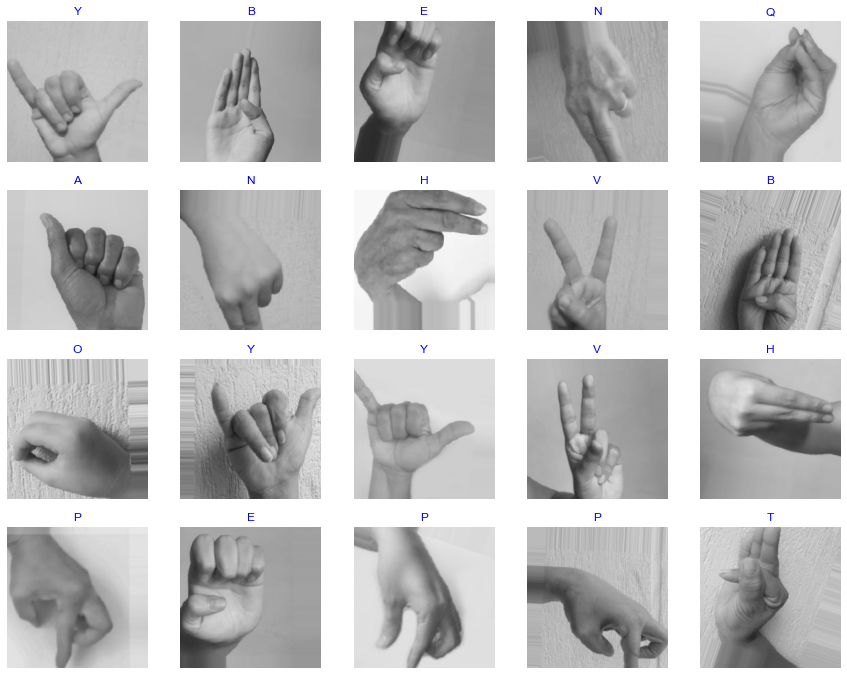

In [14]:
show_image_samples(img_train_gen)


In [15]:

cnn_base = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max',
)
x = cnn_base.output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=cnn_base.input, outputs=output)


sgd = optimizers.SGD(lr=1E-2, momentum=0.91,decay=5**(-4), nesterov=True)
Y ADAM

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])


In [17]:
def my_learning_rate(epoch, lrate):
    return lrate


lrs = LearningRateScheduler(my_learning_rate)


In [18]:
logdir = os.path.join(
    path_file, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
cnn_fit = model.fit(img_train_gen,
                    steps_per_epoch=train_steps,
                    epochs=epoch,
                    validation_data=img_val_gen,
                    validation_steps=test_steps,
                    callbacks=[tensorboard_callback, lrs],
                    verbose=1,
                    initial_epoch=0)


Epoch 1/30


KeyboardInterrupt: 

In [ ]:
pd_model_history = pd.DataFrame(cnn_fit.history)
log_name = str(
    'log-'+datestring+'.xlsx')
path_classification_report_csv = os.path.join(
    path_file, log_name)
pd_model_history.to_excel(
    path_classification_report_csv, index=True)


In [ ]:
bal = train_df['labels'].value_counts()
fig, ax = plt.subplots(figsize=(16, 9))
# Creamos Gráfica y ponesmos las barras de color verde
  # oculta la cuadricula
bar_train =ax.barh(bal.index, bal.values)
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
plt.ylabel('Letters')
plt.xlabel('Quantity')
ax.bar_label(bar_train, padding=5)
plt.title('Balance Train Dataset')
plt.savefig(os.path.join(path_file, 'Balance_Train_Dataset.jpg'),
                            dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()


In [ ]:

%tensorboard --logdir 'c:/Users/AnonimusXD/Documents/Model Proyecto de grado/saved_model'


In [ ]:
acc = cnn_fit.history['accuracy']
val_acc = cnn_fit.history['val_accuracy']

loss = cnn_fit.history['loss']
val_loss = cnn_fit.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(os.path.join(path_file, 'TA-VA-TL-VL.jpg'))
plt.show()


In [ ]:
# Generate generalization metrics
score = model.evaluate(img_test_gen, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')


In [ ]:
# # Save the model
name_model_save = str('model-'+model_name+'-'+datestring+'.h5')
if os.path.isdir(path_file):
    print('La carpeta existe.')
else:
    os.mkdir(path_file)
filefolder_model = os.path.join(path_file, name_model_save)
model.save(filefolder_model)


In [ ]:
# # Save dataframe validation
name_csv_df_val = str('temp-path-img-'+model_name+'-'+datestring+'.csv')
filefolder_dfv = os.path.join(path_file, name_csv_df_val)
test_df.to_csv(filefolder_dfv, encoding='utf-8', index=False)


In [ ]:
# create csv with classes
Class_series = pd.Series(classes, name='class')
class_df = pd.concat([Class_series], axis=1)
csv_name = 'class.csv'
csv_save_class = os.path.join(path_file, csv_name)
class_df.to_csv(csv_save_class, index=True, index_label='index')


In [ ]:
predicted = model.predict(img_test_gen, verbose=1)
print_code = 0


In [ ]:
def print_in_color(txt_msg, fore_tupple, back_tupple,):
    # prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    # text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + \
        ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)  # returns default print color to back to black
    return


In [ ]:
def plot_ci(cm, param, alpha=0.05, method="normal-approx"):
    """
    Plot two-sided confidence interval.

    :param cm: ConfusionMatrix
    :type cm : pycm.ConfusionMatrix object
    :param param: input parameter
    :type param: str
    :param alpha: type I error
    :type alpha: float
    :param method: binomial confidence intervals method
    :type method: str
    :return: None
    """
    conf_str = str(round(100*(1-alpha)))
    print(conf_str+"%CI :")
    if param in cm.class_stat.keys():
        mean = []
        error = [[], []]
        data = cm.CI(param, alpha=alpha, binom_method=method)
        class_names_str = list(map(str, (cm.classes)))
        for class_index, class_name in enumerate(cm.classes):
            """ print(str(class_name)+" : "+str(data[class_name][1])) """
            mean.append(cm.class_stat[param][class_name])
            error[0].append(cm.class_stat[param][class_name] -
                            data[class_name][1][0])
            error[1].append(data[class_name][1][1] -
                            cm.class_stat[param][class_name])
        fig, ax = plt.subplots(figsize=(10, 22))
        """ fig = plt.figure() """
        plt.errorbar(mean, class_names_str, xerr=error,
                     fmt='o', capsize=5, linestyle="dotted")
        plt.ylabel('Class')
        fig.suptitle("Param :"+param + ", Alpha:"+str(alpha), fontsize=16)
        for index, value in enumerate(mean):
            down_point = data[cm.classes[index]][1][0]
            up_point = data[cm.classes[index]][1][1]
            plt.text(value, class_names_str[index], "%f" %
                     value, ha="center", va="top", color="red")
            plt.text(down_point, class_names_str[index], "%f" %
                     down_point, ha="right", va="bottom", color="red")
            plt.text(up_point, class_names_str[index], "%f" %
                     up_point, ha="left", va="bottom", color="red")
    else:
        mean = cm.overall_stat[param]
        data = cm.CI(param, alpha=alpha, binom_method=method)
        print(data[1])
        error = [[], []]
        up_point = data[1][1]
        down_point = data[1][0]
        error[0] = [cm.overall_stat[param] - down_point]
        error[1] = [up_point - cm.overall_stat[param]]
        fig, ax = plt.subplots(figsize=(10, 22))
        """ fig = plt.figure() """
        plt.errorbar(mean, [param], xerr=error, fmt='o',
                     capsize=5, linestyle="dotted")
        fig.suptitle("Alpha:"+str(alpha), fontsize=16)
        plt.text(mean, param, "%f" % mean, ha="center", va="top", color="red")
        plt.text(down_point, param, "%f" % down_point,
                 ha="right", va="bottom", color="red")
        plt.text(up_point, param, "%f" %
                 up_point, ha="left", va="bottom", color="red")

    plt.show()


In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, classes, average="macro"):
    fig, c_ax = plt.subplots(1, 1, figsize=(12, 8))
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(classes):
        fpr, tpr, thresholds = roc_curve(
            y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, label='%s (AUC:%0.3f)' % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'k--', label='Random Guessing')
    c_ax.annotate('Random Guess', (.5, .48), color='black')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.savefig(os.path.join(path_file, 'multiclass_roc_auc_score.jpg'),
                dpi=300, bbox_inches='tight', pad_inches=0.5)
    plt.show()
    print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))


In [ ]:
def print_info(test_gen, preds):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    for key, value in class_dict.items():
        # dictionary {integer of class number: string of class name}
        new_dict[value] = key
    # store new_dict as a text fine in the save_dir
    classes = list(new_dict.values())     # list of string of class names
    errors = 0
    # False Negative
    x_predic = []
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        x_predic.append(pred_index)
        true_index = labels[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)

    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # create a confusion matrix
        cm2 = ConfusionMatrix(actual_vector=y_true, predict_vector=y_pred)
        class_stat = pd.DataFrame(cm2.class_stat).transpose()
        class_stat_csv = str(
            'class_stat_'+datestring+'.xlsx')
        class_stat_report_csv = os.path.join(
            path_file, class_stat_csv)
        class_stat.to_excel(
            class_stat_report_csv, index=True)

        fn_cm = cm2.FN
        fp_cm = cm2.FP
        tn_cm = cm2.TN
        tp_cm = cm2.TP
        count_fp = 0
        count_fn = 0
        count_tn = 0
        count_tp = 0

        fig, ax = plt.subplots(figsize=(10, 2))
        for k, v in fn_cm.items():
            if v > 0:
                bar_char_fn = ax.barh(classes[k], v, color='gray')
                count_fn += v
                plt.ylabel('Letters')
                plt.xlabel('Quantity')
                plt.title('False Negative = '+str(count_fn))
                ax.bar_label(bar_char_fn, padding=5)
                plt.savefig(os.path.join(path_file, 'False Negative.jpg'),
                            dpi=300, bbox_inches='tight', pad_inches=0.5)

        fig, ax = plt.subplots(figsize=(10, 2))
        for k, v in fp_cm.items():
            if v > 0:
                bar_char_fp = ax.barh(classes[k], v, color='gray')
                count_fp += v
                plt.ylabel('Letters')
                plt.xlabel('Quantity')
                plt.title('False Positive = '+str(count_fp))
                ax.bar_label(bar_char_fp, padding=5)
                plt.savefig(os.path.join(path_file, 'False Positive.jpg'),
                            dpi=300, bbox_inches='tight', pad_inches=0.5)

        fig, ax = plt.subplots(figsize=(10, 10))
        for k, v in tn_cm.items():
            if v > 0:
                bar_char_tn = ax.barh(classes[k], v, color='gray')
                count_tn += v
                plt.ylabel('Letters')
                plt.xlabel('Quantity')
                plt.title('True Negative = '+str(count_tn))
                ax.bar_label(bar_char_tn, padding=5)
                plt.savefig(os.path.join(path_file, 'True Negative.jpg'),
                            dpi=300, bbox_inches='tight', pad_inches=0.5)
        fig, ax = plt.subplots(figsize=(10, 10))
        for k, v in tp_cm.items():
            if v > 0:
                bar_char_tp = ax.barh(classes[k], v, color='gray')
                count_tp += v
                plt.ylabel('Letters')
                plt.xlabel('Quantity')
                plt.title('True Positive = '+str(count_tp))
                ax.bar_label(bar_char_tp, padding=5)
                plt.savefig(os.path.join(path_file, 'True Positive.jpg'),
                            dpi=300, bbox_inches='tight', pad_inches=0.5)

        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues')
        plt.xticks(np.arange(length)+.5, classes, rotation=90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("True Class")
        plt.title("Confusion Matrix")
        plt.savefig(os.path.join(path_file, 'confusion_matrix.jpg'),
                    dpi=300, bbox_inches='tight', pad_inches=0.5)
        plt.show()
    clr = classification_report(
        y_true, y_pred, target_names=classes, output_dict=True)

    df_classification_report = pd.DataFrame(clr).transpose()

    name_classification_report_csv = str(
        'classification_report-'+datestring+'.xlsx')
    path_classification_report_csv = os.path.join(
        path_file, name_classification_report_csv)
    df_classification_report.to_excel(
        path_classification_report_csv, index=True)
    """ print("Classification Report:\n----------------------\n",
          df_classification_report) """
    multiclass_roc_auc_score(y_true, x_predic, classes)


print_info(img_test_gen, predicted)


In [ ]:
def plot_image(predictions_array, class_df, true_label, img, i):
    predictions_array, true_label = predictions_array, true_label
    plt.figure(figsize=(20, 6))
    grid = plt.GridSpec(1, 5, hspace=0.2, wspace=0.2)
    plt.subplot(grid[0, 0])
    plt.grid(b=None)
    plt.imshow(img)
    predicted_label = class_df.iloc[np.argmax(predictions_array)]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} {:6.2f}% ({})".format(predicted_label,
                                         100*np.max(predictions_array),
                                         true_label),
               color=color)
    plt.subplot(grid[0, 1:])
    plt.xticks(range(len(classes)), classes)
    thisplot = plt.bar(range(len(classes)), predictions_array, color="#777777")
    ax.bar_label(thisplot, label_type='center')
    plt.ylim([0, 1])
    p_label = np.argmax(predictions_array)
    thisplot[p_label].set_color('red')
    thisplot[classes.index(true_label)].set_color('green')
    i = 0
    for p in thisplot:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                 y+height*1.01,
                 str(round(predictions_array[i]*100, 2))+'%',
                 ha='center',
                 weight='bold')
        i += 1
    if i < 5:
        plt.savefig(os.path.join(path_file, str(i)+'_'+str(true_label)+'_predict_test.jpg'),
                    dpi=300, bbox_inches='tight', pad_inches=0.5)
    plt.show()


In [ ]:
def classify_with_model(i_, class_csv_path, filefolder_val_img,  model_path):
    # read in the csv file
    class_df = pd.read_csv(class_csv_path)
    images_csv = pd.read_csv(filefolder_val_img)
    crop_image = False
    img_height = 224
    img_width = 224
    img_size_ = (img_width, img_height)
    scale = 1
    try:
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split('-')
        s1 = float(split[1])
        s2 = float(split[0].split('*')[1])
        print(s1, s2)
    model = load_model(model_path)
    for i in range(i_):
        rand = random.randint(0, len(images_csv['filepaths']))
        image_path = images_csv['filepaths'].iloc[rand]
        class_img_path = images_csv['labels'].iloc[rand]
        img = plt.imread(image_path)
        img = cv2.resize(img, img_size_)
        img_use = img
        img = img*s2 - s1
        img = np.expand_dims(img, axis=0)
        p = np.squeeze(model.predict(img))
        plot_image(p, class_df['class'], class_img_path, img_use, i)
        plt.show()


In [ ]:
from pathlib import Path


def create_galery_val():
    path_imgs = filefolder_dfv
    images_csv = pd.read_csv(path_imgs)
    filepath_img = []
    labels_img = []
    store_path = os.path.join(
        path_file, 'storage-img-'+model_name+'-'+datestring)
    os.mkdir(store_path)
    for i in range(len(images_csv['filepaths'])):
        image_path = images_csv['filepaths'].iloc[i]
        class_img_path = images_csv['labels'].iloc[i]
        img = cv2.imread(image_path)
        file_name = os.path.split(image_path)[1]
        dst_path = os.path.join(store_path, file_name)
        filepath_img.append(dst_path)
        labels_img.append(class_img_path)
        cv2.imwrite(dst_path, img)
    Fseries = pd.Series(filepath_img, name='filepaths')
    Lseries = pd.Series(labels_img, name='labels')
    df_img_val_new_file = pd.concat([Fseries, Lseries], axis=1)
    name_csv_df_val = str('new-'+model_name+'-'+datestring+'.csv')
    filefolder_val_img = os.path.join(path_file, name_csv_df_val)
    df_img_val_new_file.to_csv(
        filefolder_val_img, encoding='utf-8', index=False)
    return store_path, filefolder_val_img


store_path_img, filefolder_val_img = create_galery_val()


In [ ]:
# save all path
data_paths = {'model': [filefolder_model],
              'class': [csv_save_class], 'img_val': [filefolder_val_img]}

origin_paths = pd.DataFrame(data_paths)
csv_name = 'origin_path.csv'
csv_save_loc = os.path.join(path_file, csv_name)
origin_paths.to_csv(csv_save_loc, index=False)


In [ ]:
import random

path_imgs = store_path_img
class_csv_path = csv_save_class
model_path = filefolder_model
num_images = 5
classify_with_model(num_images, class_csv_path,
                    filefolder_val_img, model_path)
